### Hypothesis Testing
#### Classical Hypothesis Testing
So far, when exploring datasets and finding several "apparent effects", like finding differences between first babies and others, we have taken these effects at face value. Now, it's time to put these effects to the test. Are these effects likely to appear in the larger population?

The goal of **classical hypothesis testing** is to answer this question:
> Given a sample and an apparent effect, what is the probability of seeing such an effect by chance?

These are the steps to answer this question:
- Quantify the size of the apparent effect by choosing a **test statistic**. In the NSFG example, the apparent effect is a difference in pregnancy lengths between first babies and others. The test statistic we can choose for this is the difference in means between the two groups; that is, `mean_first - mean_others`. As shown below, the test statistic came up positive, which means that the data shows that, on average, live firstborns have longer pregnancy lengths than others, and thus are born later than others. But since we know that means are skewed by outliers, we can also show the median difference between the two groups. The median difference ended up at exactly 0.

In [24]:
import numpy as np
import pandas as pd

df = pd.read_pickle("nsfg_data.pkl")
live = df[df["outcome"] == 1]
firsts = live[live["birthord"] == 1]["prglngth"]
others = live[live["birthord"] != 1]["prglngth"]
diffMean = firsts.mean() - others.mean()
diffMedian = firsts.median() - others.median()
print("Test statistic\n", "\tDifference of mean pregnancy lengths between firsts and others:", diffMean)
print("\tDifference of median pregnancy lengths between firsts and others:", diffMedian)

Test statistic
 	Difference of mean pregnancy lengths between firsts and others: 0.07803726677754952
	Difference of median pregnancy lengths between firsts and others: 0.0


- Define a **null hypothesis**, which is a model of the system based on the assumption that the apparent effect is **NOT** real. In the NSFG example, the null hypothesis is that there is no difference between the pregnancy lengths of the first babies and others; that is, the pregnancy lengths for both groups have the same distribution.
- Compute a **p-value**, which is the probability of seeing the apparent effect if the null hypothesis is **true**. For the NSFG example, as done in code:

In [58]:
def GetPValue(group1, group2):
    # MakeModel
    group1Count = len(group1)
    group2Count = len(group2)

    # Create a pool of pregnancy length values by combining the values of the firsts and others in one array
    pool = np.hstack((group1, group2))

    # RunModel
    testStatistics = []
    iterations = 1000
    for i in range(iterations):
        # Destructively shuffle the pool
        np.random.shuffle(pool)
        group1TestData = pool[:group1Count] # should be of size firstsCount
        group2TestData = pool[group1Count:] # since this is the leftover, it will be of size othersCount

        # TestModel
        testStatistic = abs(group1TestData.mean() - group2TestData.mean())
        testStatistics.append(testStatistic)

    # Find p-value
    actualTestStatistic = abs(group1.mean() - group2.mean()) # Based on the actual values of firsts and others
    count = sum(1 for x in testStatistics if x >= actualTestStatistic)
    pValue = count / iterations
    return (pValue, testStatistics, actualTestStatistic)

pValue, testStatistics, actualTestStatistic = GetPValue(firsts, others)
print("P-Value:", pValue, "or", pValue * 100, "%", "\nDifference in pregnancy lengths:", actualTestStatistic)

P-Value: 0.17 or 17.0 % 
Difference in pregnancy lengths: 0.07803726677754952


- Finally, we interpret the result. If the p-value is low, the effect is said to be **statistically significant**, which means that it is unlikely to have occurred by chance. We can then infer that the effect is more likely to appear in the larger population. Based on the p-value above, we get a value of `0.17` or `17%`. This means that we expect to see a difference as big as the observed effect about 17% of the time, therefore this effect is **NOT** statistically significant. If we were to graph the differences of the means of pregnancy lengths in a CDF graph and mark where the actual mean difference is, it would look like this:

In [49]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from cycler import cycler

matplotlib.style.use("dark_background")
%matplotlib inline
rcParams["figure.figsize"] = (15, 6)
rcParams["axes.prop_cycle"] = cycler(color=["#4299E1", "#F56565", "#48BB78"])
rcParams["axes.facecolor"] = "#1A202C"
rcParams["axes.edgecolor"] = "#A0AEC0"
rcParams["axes.grid"] = True
rcParams["grid.color"] = "#A0AEC0"
rcParams["grid.alpha"] = 0.7
rcParams["axes.titlecolor"] = "#A0AEC0"
rcParams["axes.labelcolor"] = "#A0AEC0"
rcParams["xtick.color"] = "#A0AEC0"
rcParams["ytick.color"] = "#A0AEC0"

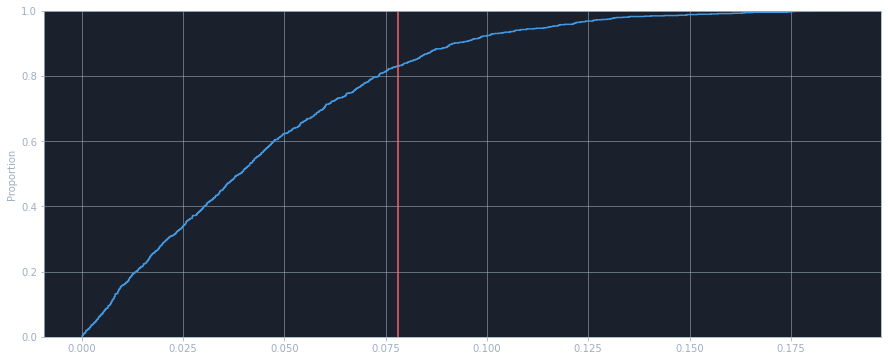

In [59]:
import seaborn as sns

sns.ecdfplot(x=testStatistics)
plt.plot([actualTestStatistic, actualTestStatistic], [0, 1])
plt.draw()

Let's try doing the same thing for birth weights:

In [62]:
firstWeights = live[live["birthord"] == 1]["totalwgt_lb"]
otherWeights = live[live["birthord"] != 1]["totalwgt_lb"]

pValue, testStatistics, actualTestStatistic = GetPValue(firstWeights, otherWeights)
print("P-Value:", pValue, "or", pValue * 100, "%", "\nDifference in weights:", actualTestStatistic)

P-Value: 0.0 or 0.0 % 
Difference in weights: 0.12476118453549034


Unlike that of pregnancy lengths, the simulation for birth weights never yields an effect as big as the observed difference, `0.12 lbs`. This means the difference in birth weight **IS** statistically significant.